# Longitudinal vs Transverse Cellular Orientation in Leiomyosarcoma
> In this mini-project, we will assess major-minor axis ratio and alignment of nuclei in H&E histopathology images of Soft Tissue Leiomyosarcoma #

In [96]:
# conda env pytorchHTK
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

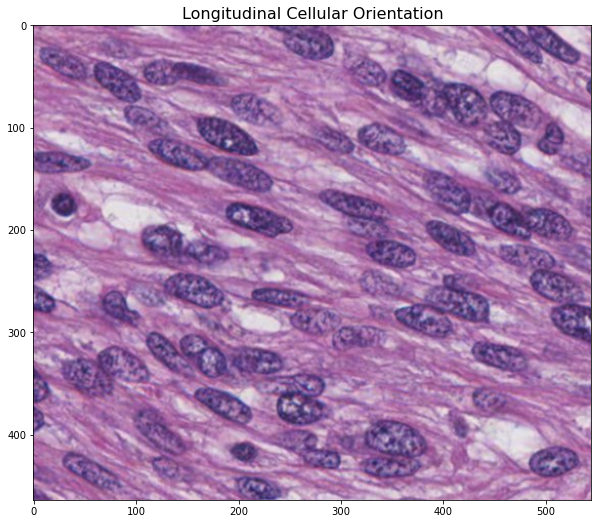

In [2]:
# Load longitudinal input image 
longitudinal_image_file = 'longitudinal.png'
long_im_input = skimage.io.imread(longitudinal_image_file)[:,:,:3]
plt.imshow(long_im_input)
_ = plt.title('Longitudinal Cellular Orientation', fontsize=16)

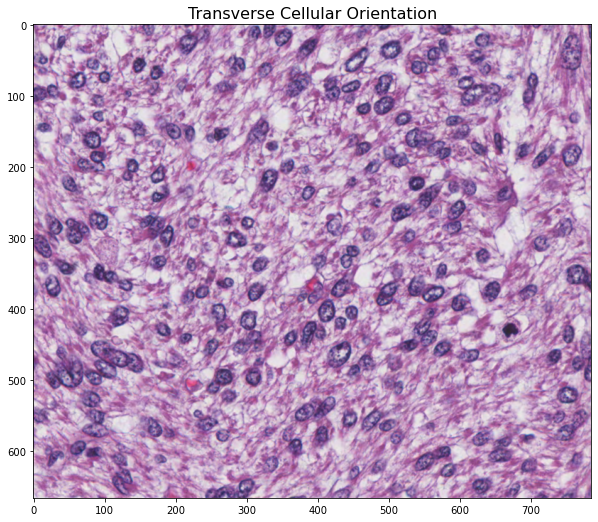

In [3]:
# Load transverse input image 
transverse_image_file = 'transverse.png'
trans_im_input = skimage.io.imread(transverse_image_file)[:,:,:3]
plt.imshow(trans_im_input)
_ = plt.title('Transverse Cellular Orientation', fontsize=16)

In [4]:
# Perform color normalization
ref_image_file = ('6070-7712.png')  # L1.png
im_reference = skimage.io.imread(ref_image_file)[:,:,:3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

In [5]:
# perform reinhard color normalization
long_im_nmzd = htk.preprocessing.color_normalization.reinhard(long_im_input, mean_ref, std_ref)
trans_im_nmzd = htk.preprocessing.color_normalization.reinhard(trans_im_input, mean_ref, std_ref)

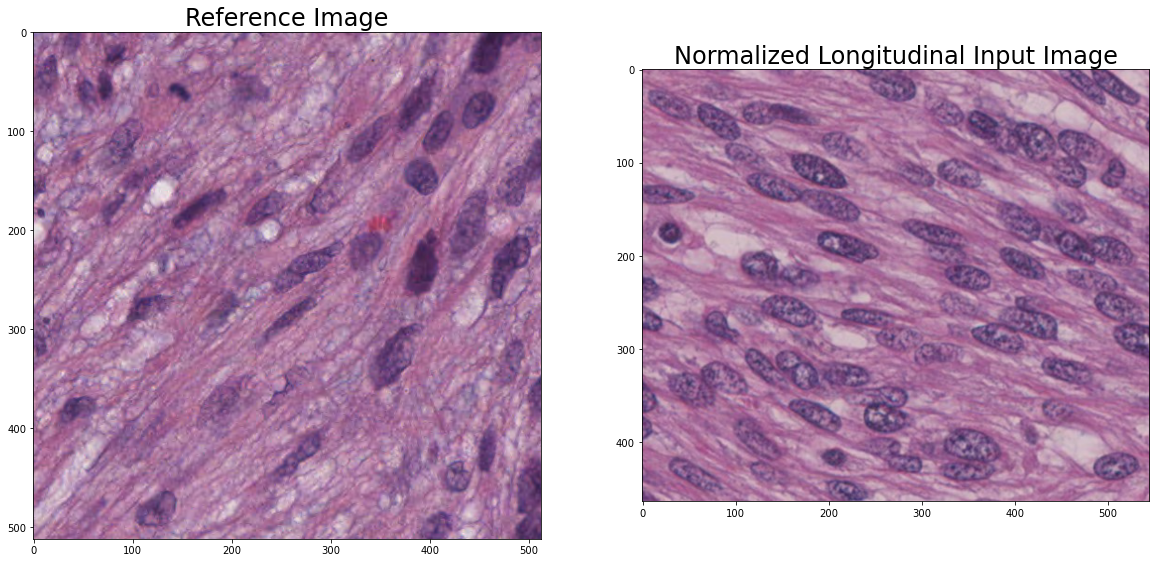

In [6]:
# Display results for longitudinal cellular orientation
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(long_im_nmzd)
_ = plt.title('Normalized Longitudinal Input Image', fontsize=titlesize)


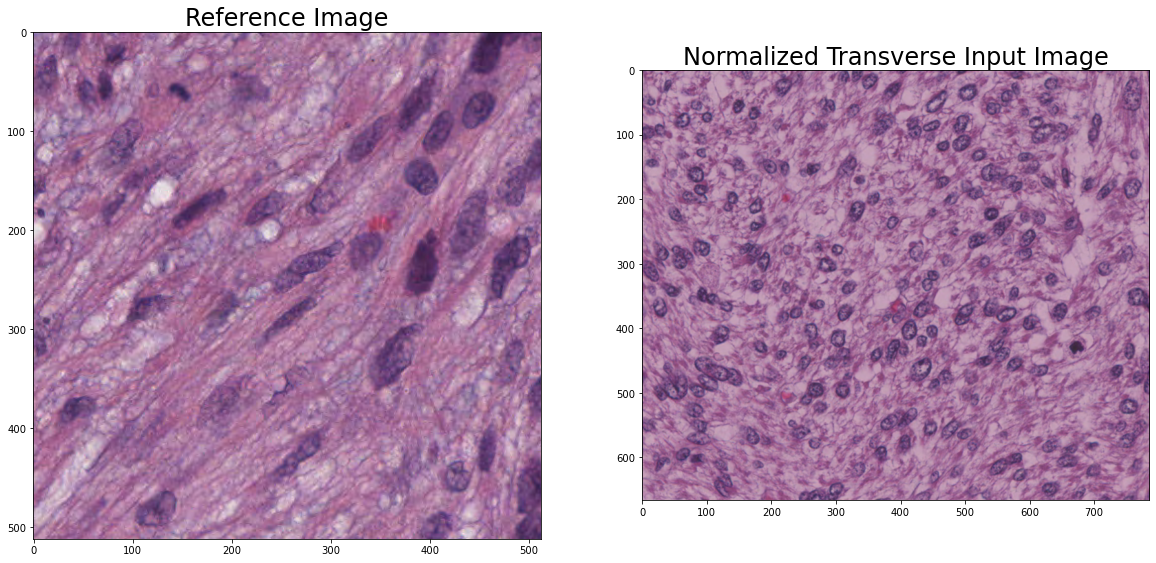

In [7]:
# Display results for transverse cellular orientation
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(trans_im_nmzd)
_ = plt.title('Normalized Transverse Input Image', fontsize=titlesize)

In [8]:
# perform color deconvolution
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null if input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T


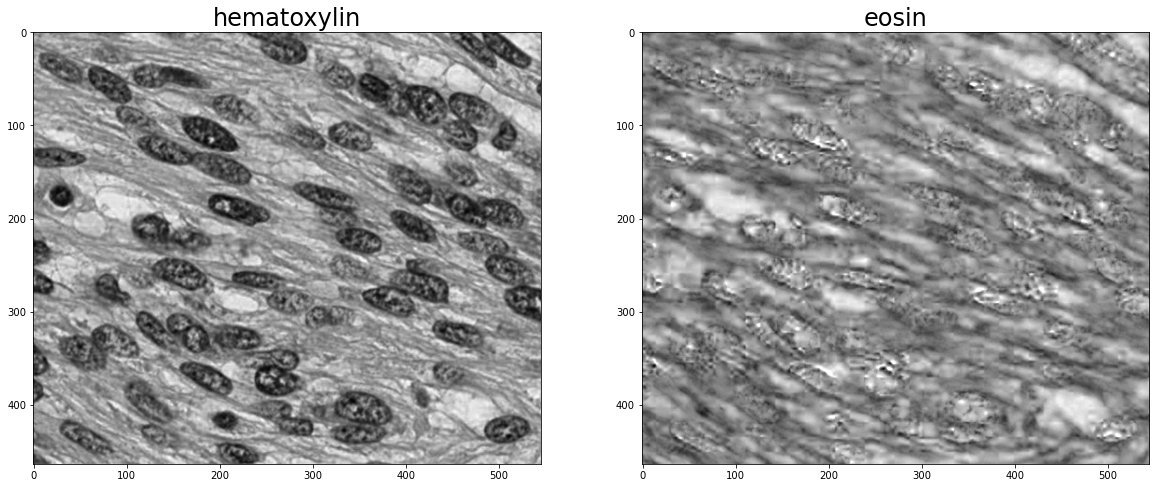

In [9]:
# perform standard color deconvolution for longitudinal cellular orientation
long_im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(long_im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(long_im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(long_im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

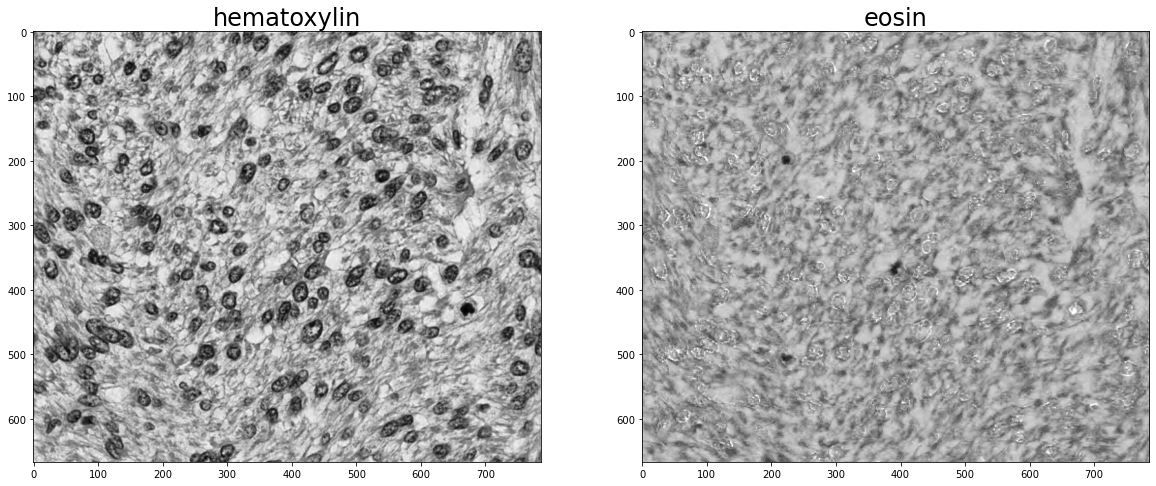

In [10]:
# perform standard color deconvolution for transverse cellular orientation
trans_im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(trans_im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(trans_im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(trans_im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

In [11]:
# Segment nuclei - Longitudinal orientation first
# get nuclei/hematoxylin channel
long_im_nuclei_stain = long_im_stains[:, :, 0]
trans_im_nuclei_stain = trans_im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

long_im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    long_im_nuclei_stain < foreground_threshold)

trans_im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    trans_im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

long_im_log_max, long_im_sigma_max = htk.filters.shape.cdog(
    long_im_nuclei_stain, long_im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

trans_im_log_max, trans_im_sigma_max = htk.filters.shape.cdog(
    trans_im_nuclei_stain, trans_im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

long_im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    long_im_log_max, long_im_fgnd_mask, local_max_search_radius)

trans_im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    trans_im_log_max, trans_im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

long_im_nuclei_seg_mask = htk.segmentation.label.area_open(
    long_im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

trans_im_nuclei_seg_mask = htk.segmentation.label.area_open(
    trans_im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
LongObjProps = skimage.measure.regionprops(long_im_nuclei_seg_mask)
TransObjProps = skimage.measure.regionprops(trans_im_nuclei_seg_mask)

print('Number of nuclei in longitudinal image = ', len(LongObjProps))
print('Number of nuclei in transverse image = ', len(TransObjProps))

Number of nuclei in longitudinal image =  43
Number of nuclei in transverse image =  122


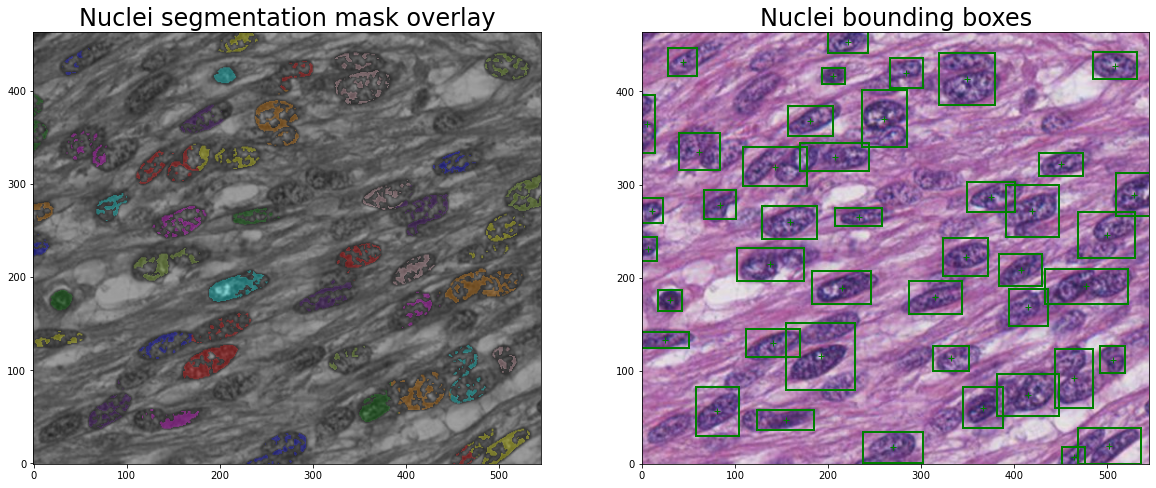

In [12]:
# Display results for longitudinally oriented image
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(long_im_nuclei_seg_mask, long_im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( long_im_input )
plt.xlim([0, long_im_input.shape[1]])
plt.ylim([0, long_im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(LongObjProps)):

    c = [LongObjProps[i].centroid[1], LongObjProps[i].centroid[0], 0]
    width = LongObjProps[i].bbox[3] - LongObjProps[i].bbox[1] + 1
    height = LongObjProps[i].bbox[2] - LongObjProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

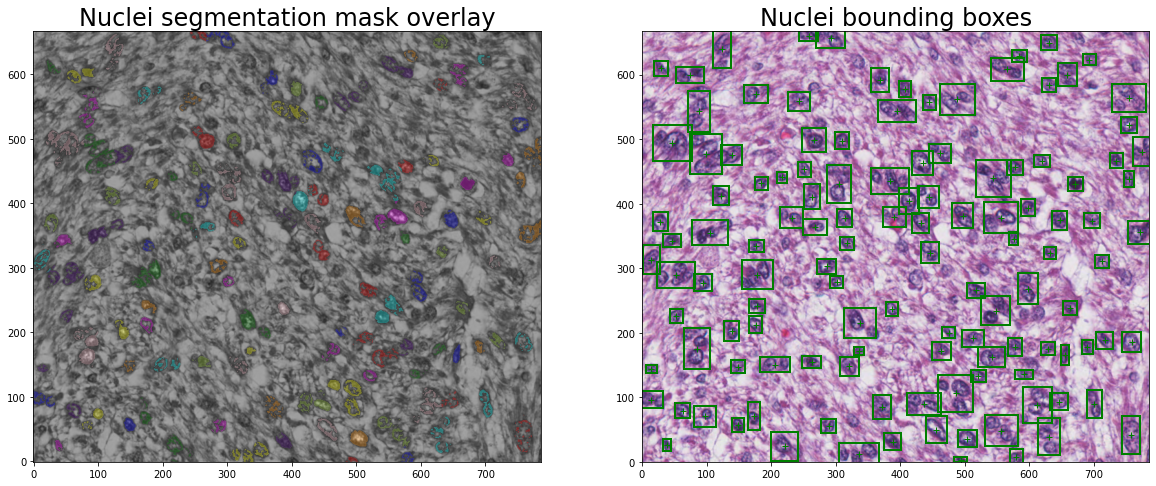

In [13]:
# Display results for transversely oriented image
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(trans_im_nuclei_seg_mask, trans_im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( trans_im_input )
plt.xlim([0, trans_im_input.shape[1]])
plt.ylim([0, trans_im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(TransObjProps)):

    c = [TransObjProps[i].centroid[1], TransObjProps[i].centroid[0], 0]
    width = TransObjProps[i].bbox[3] - TransObjProps[i].bbox[1] + 1
    height = TransObjProps[i].bbox[2] - TransObjProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

In [14]:
# extract nuclei properties in table for easier handling
LongObjPropsTable = skimage.measure.regionprops_table(long_im_nuclei_seg_mask,
                                                     properties=('label',
                                                                 'orientation',
                                                                'major_axis_length',
                                                                'minor_axis_length',)
                                                     )

In [15]:
TransObjPropsTable = skimage.measure.regionprops_table(trans_im_nuclei_seg_mask,
                                                       properties=('label',
                                                                 'orientation',
                                                                'major_axis_length',
                                                                'minor_axis_length')
                                                     )

In [16]:
long_orientation = LongObjPropsTable['orientation']
trans_orientation = TransObjPropsTable['orientation']

In [87]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

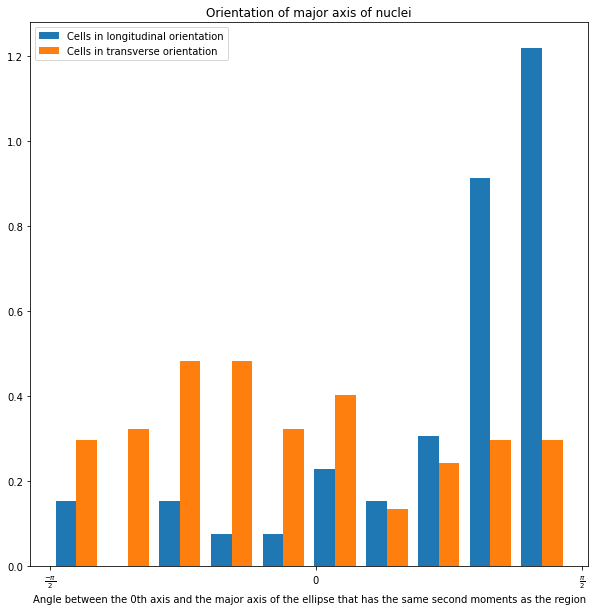

In [95]:
_ = plt.hist(x = (long_orientation, trans_orientation),
             density=True,
            )

plt.xlabel('Angle between the 0th axis and the major axis of the ellipse that has the same second moments as the region')
plt.title("Orientation of major axis of nuclei")
plt.legend(['Cells in longitudinal orientation',
            'Cells in transverse orientation'])
ax = plt.gca()

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
plt.show()

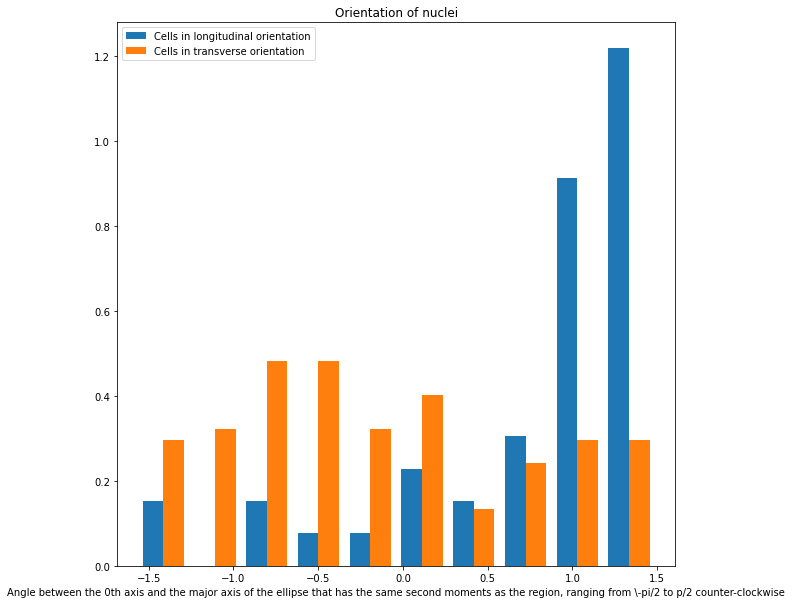

In [89]:
_ = plt.hist(x = (long_orientation, trans_orientation),
             density=True,
            )

plt.xlabel('Angle between the 0th axis and the major axis of the ellipse that has the same second moments as the region, ranging from \-pi/2 to p/2 counter-clockwise')
plt.title("Orientation of nuclei")
plt.legend(['Cells in longitudinal orientation',
            'Cells in transverse orientation'])
plt.show()

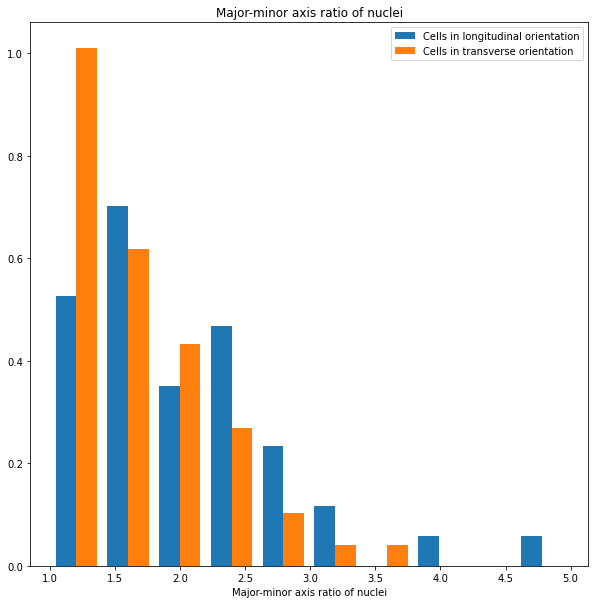

In [77]:
_ = plt.hist(x = (long_major_minor_ratio, trans_major_minor_ratio),
            density=True,
            )

plt.xlabel("Major-minor axis ratio of nuclei")
plt.title("Major-minor axis ratio of nuclei")
plt.legend(['Cells in longitudinal orientation',
            'Cells in transverse orientation'])
plt.show()

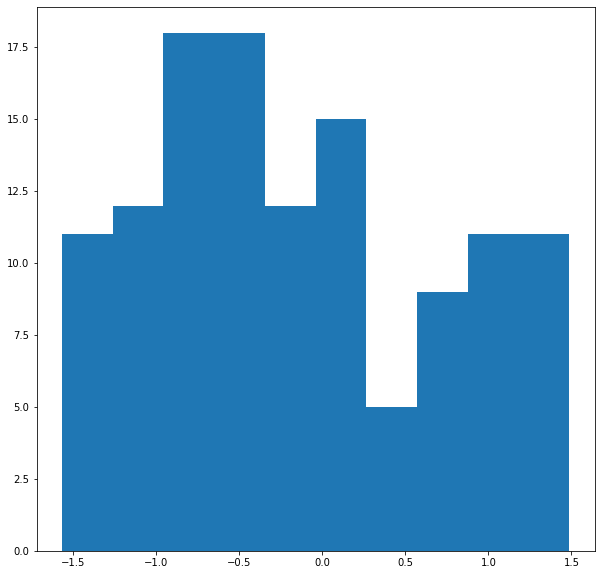

In [75]:
_ = plt.hist(trans_orientation)
plt.show()

In [39]:
long_minor = LongObjPropsTable['minor_axis_length']
trans_minor = TransObjPropsTable['minor_axis_length']

In [40]:
long_major = LongObjPropsTable['major_axis_length']
trans_major = TransObjPropsTable['major_axis_length']

In [41]:
long_major_minor_ratio = long_major / long_minor
trans_major_minor_ratio = trans_major / trans_minor

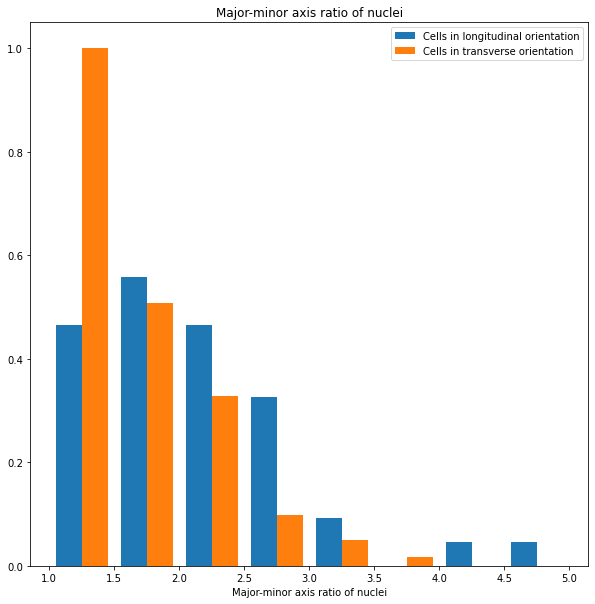

In [71]:
_ = plt.hist(x = (long_major_minor_ratio, trans_major_minor_ratio),
            bins=[1,1.5,2,2.5,3,3.5,4,4.5,5],
            density=True,
            histtype = 'bar',
            
            )
plt.xlabel("Major-minor axis ratio of nuclei")
plt.title("Major-minor axis ratio of nuclei")
plt.legend(['Cells in longitudinal orientation',
            'Cells in transverse orientation'])
plt.show()